In [28]:
import cv2
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../')
import TreeConverter as tc
# added imports
from Bio import Phylo
from io import StringIO

In [29]:
class Leaf:
  def __init__(self, coordinates, name):
    self.left = None
    self.right = None
    self.coordinates = coordinates
    self.name = name

class BinNode:
  def __init__(self, left, right, coordinates, name=None):
    self.coordinates = coordinates
    self.left = left
    self.right = right
    self.name = name
  
  def generate_newick_node(self, newick=''):
    """
    Generates newick string for a node
    """
    if self.left != None:
      newick += '('
      if isinstance(self.left, Leaf):
        newick += self.left.name
      else:
        newick = self.left.generate_newick_node(newick=newick)
    
    newick += ','

    if self.right != None:
      if not isinstance(self.right, Leaf):
        newick = self.right.generate_newick_node(newick=newick)
      else:
        newick += self.right.name
      newick += ')'
      
    return newick

class BinTree: 
  def __init__(self,node=None):
    self.root = node
  
  def generate_newick(self):
    """
    Generates newick string for a tree
    """
    if self.root != None:
      newick = self.root.generate_newick_node()
    else:
      newick = ''
    return newick


def leaves_list2class(leaves: list, labels: list=None) -> list:
  """
  Converts list of leaves coordinates to list of Leaf objects
  """
  leaves = sorted(leaves)
  if not labels:
    return [Leaf(leaf, f'leaf_{str(leaf[0]).split(".")[0]}_{str(leaf[1]).split(".")[0]}') for i, leaf in enumerate(leaves)]
  else:
    assert len(leaves) == len(labels), "Leaves and labels must have the same length"
    return [Leaf(leaf, label) for leaf, label in zip(leaves, labels)]


def find_the_nearest_leaves(leaves: set, node: tuple) -> tuple:
    """
    Find the nearest (on the x-axis) leaves between which a given node is located.
    Args:
        leaves (set): set of leaves to search
        node (tuple): node coordinates
    Returns:
        tuple: nearest left leaf, nearest right leaf
    """
    x, _ = node
    nearest_left = None
    nearest_right = None
    for leaf in leaves:
        if leaf.coordinates[0] < x:
            if nearest_left is None:
                nearest_left = leaf
            elif nearest_left.coordinates[0] <= leaf.coordinates[0]:
                #assert nearest_left.coordinates[0] != leaf.coordinates[0], "Leaves cannot have the same x-coordinate"
                nearest_left = leaf
        
        if leaf.coordinates[0] > x:
            if nearest_right is None:
                nearest_right = leaf       
            elif nearest_right.coordinates[0] >= leaf.coordinates[0]:
                #assert nearest_right.coordinates[0] != leaf.coordinates[0], "Leaves cannot have the same x-coordinate"
                nearest_right = leaf
    
    return nearest_left, nearest_right

def rotate_coordinates(coordinates: list) -> list:
    """
    Rotates coordinates.
    Args:
        coordinates (list): list of coordinates
    Returns:
        list: rotated coordinates
    """
    return [(y, x) for x, y in coordinates]


def create_tree(leaves: list, nodes: list, orientation: str, labels: list=None) -> BinTree:
    """
    Creates a binary tree from a lists of leaves and nodes.
    Args:
        leaves (list): list of leaves coordinates
        nodes (list): list of nodes coordinates
        orientation (str): orientation of the tree
        labels (list): list of labels for leaves
    Returns:
        BinTree: binary tree
    """
    # Rotate coordinates if needed
    if orientation == 'horizontal':
       leaves = rotate_coordinates(leaves)
       nodes = rotate_coordinates(nodes) 
    # Replace spaces in labels with underscores
    if labels:
      labels = [label.replace(' ', '_') for label in labels]
      
    leaves = leaves_list2class(leaves, labels)
    nodes_y_asc = sorted(nodes, key=lambda x: x[1])
    leaves_to_search = set(leaves)
    created_nodes = []
    while len(leaves_to_search) > 2:
        node = nodes_y_asc.pop()
        nearest_left, nearest_right = find_the_nearest_leaves(leaves_to_search, node)
        new_node = BinNode(nearest_left, nearest_right, node, name=f'node_{str(node[0]).split(".")[0]}_{str(node[1]).split(".")[0]}')
        created_nodes.append(new_node)
        # Remove used leaves and add newly created node as artificial leaf
        leaves_to_search.remove(nearest_left)
        leaves_to_search.remove(nearest_right)
        leaves_to_search.add(new_node)
    # Create artificial root node
    root_x = np.mean([leaf.coordinates[0] for leaf in leaves_to_search])
    root_y = np.mean([leaf.coordinates[1] for leaf in leaves_to_search]) + 10
    leaves_to_search = sorted(list(leaves_to_search), key=lambda x: x.coordinates[0])
    root_node = BinNode(leaves_to_search[0], leaves_to_search[1], (root_x, root_y), name='root')

    return BinTree(root_node)


def generate_newick_str(leaves: list, nodes: list, orientation: str='horizontal', labels: list=None) -> str:
  """
  Generates newick string from a lists of leaves and nodes.
  Args:
      leaves (list): list of leaves coordinates
      nodes (list): list of nodes coordinates
      orientation (str): orientation of the tree
      labels (list): list of labels for leaves
  Returns:
      str: newick string
  """
  tree = create_tree(leaves, nodes, orientation, labels)
  return tree.generate_newick()


def save_to_newick(newick: str, path: str) -> None:
  """
  Saves newick string to a file.
  Args:
      newick (str): newick string
      path (str): path to the file
  """
  with open(path, 'w') as f:
    f.write(newick)


def draw_newick(newick: str, path: str) -> None:
  """
  Draws a tree from newick string.
  Args:
      newick (str): newick string
      path (str): path to the file
  """
  newick = StringIO(newick)
  tree_newick = Phylo.read(newick, 'newick')
  Phylo.draw(tree_newick, do_show=False)
  plt.savefig(path)


Example 1

Tree image will be saved to ../test_data/dendrogram3_tree.png.
Retrieved labels: Human Brown Bat Bonobo Lemur Orca Wild Boar Chinchilla Clawed Frog Saker Falcon Sea Turtle Alligator Ghostshark Zebrafish Northern Pike Damselfish Yellow Croaker Tilapia Maylandia Japanese Rice Fish
Number of y points with frequency > 100: 95
Number of x points with frequency > 100: 104
[Step 1] finding and plotting all intersections
[Step 2] filtering internal nodes (line intersections)
Initial number of intersections = 126
After filtering number of intersections = 17
[Step 3] filtering leaves (line endings)
Initial number of intersections = 48
After filtering number of intersections = 19
[Summary] number of leaves = 19, number of nodes = 17


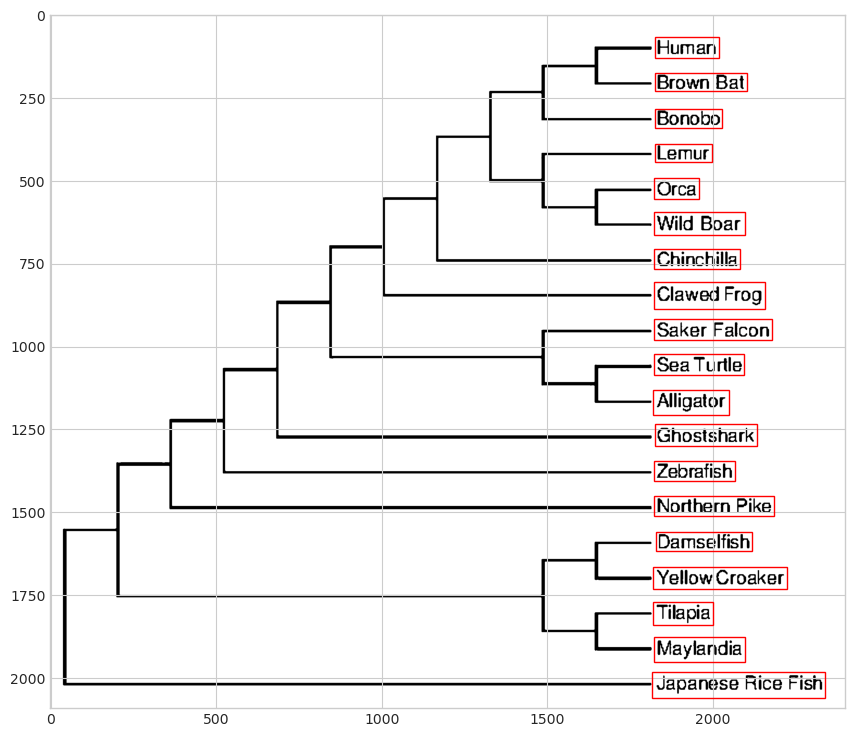

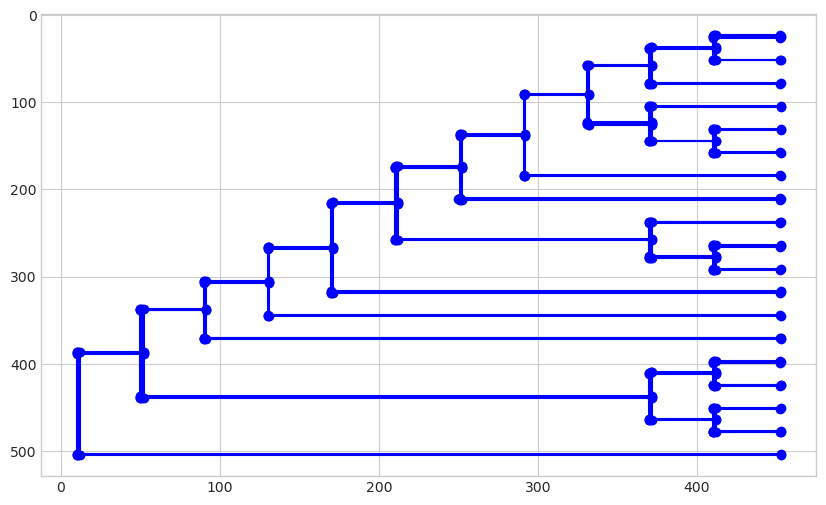

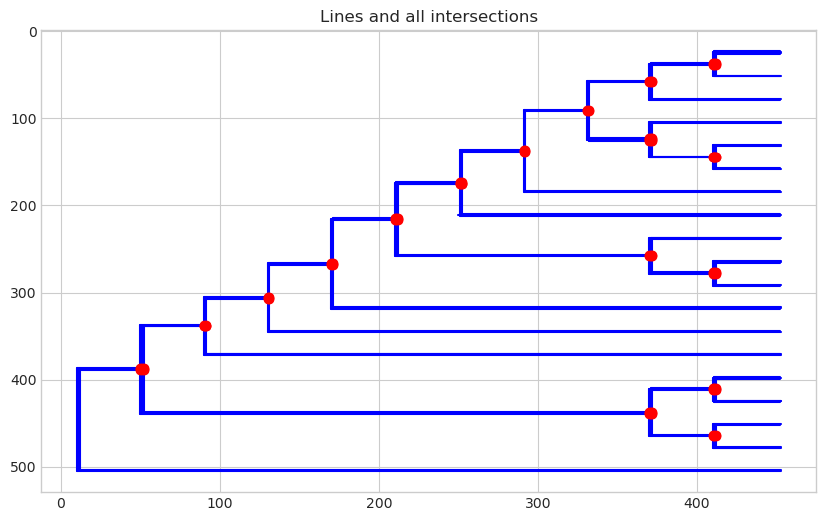

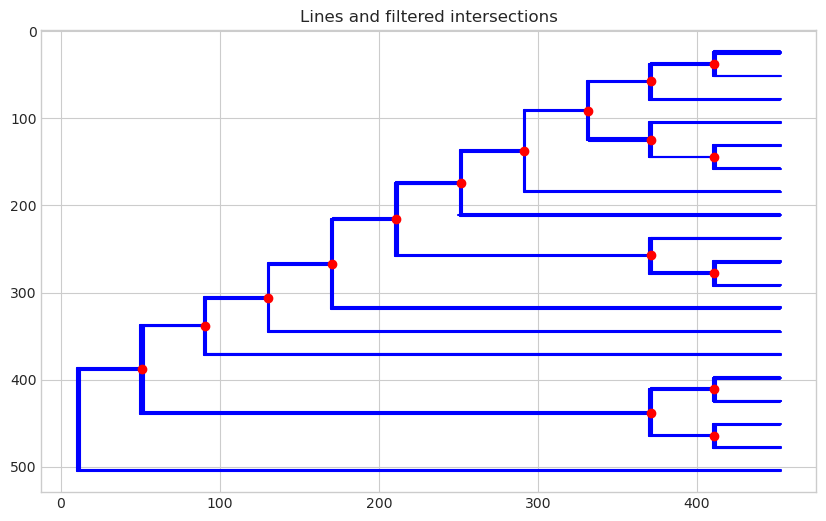

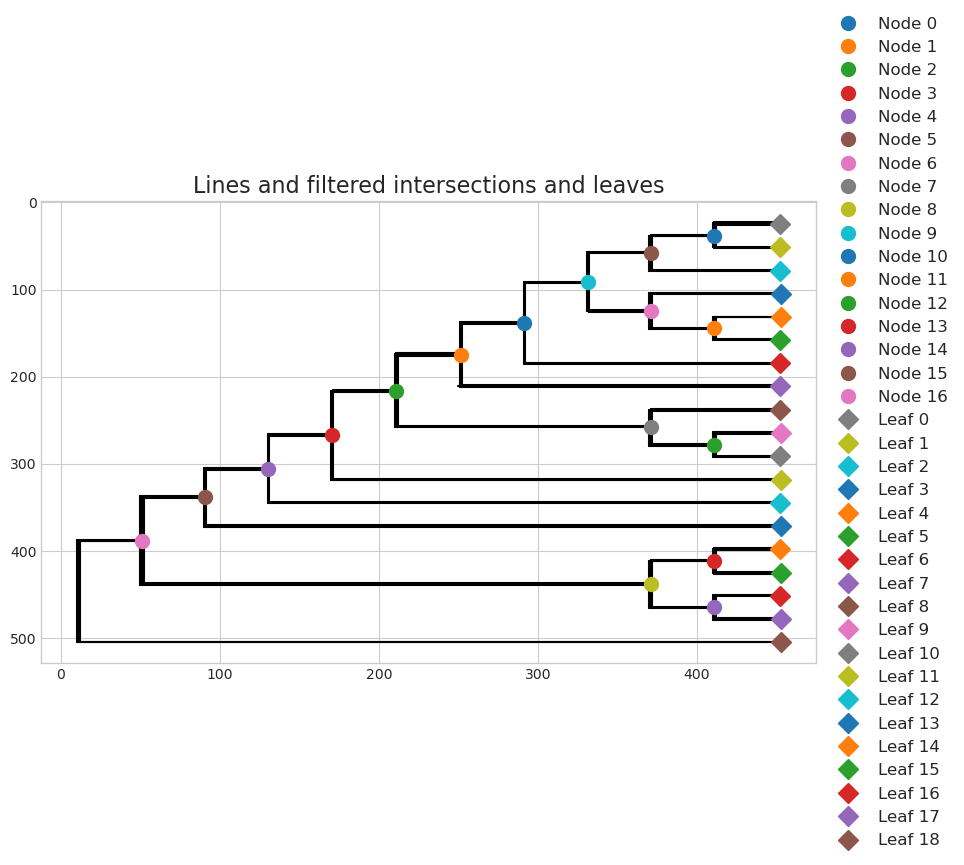

In [30]:
image = tc.Image('../test_data/dendrogram3.png', resize_factor=0.25)
_, _, internal_nodes, leaves, _ = image.tree_image.find_lines_intersections_leaves(legend=True,orientation='horizontal',
                                                 intersection_threshold=5, min_freq=100)

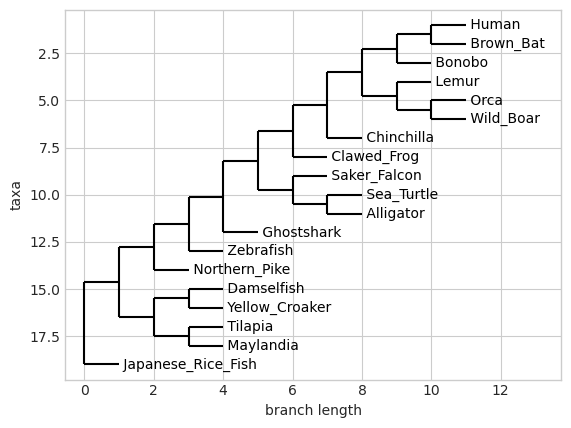

In [31]:
newick = generate_newick_str(leaves, internal_nodes, orientation='horizontal', labels=image.labels)
save_to_newick(newick, '../newick_results/dendrogram3.txt')
draw_newick(newick, '../newick_results/dendrogram3.png')

Example 2

Number of y points with frequency > 10: 75
Number of x points with frequency > 10: 22
[Step 1] finding and plotting all intersections
[Step 2] filtering internal nodes (line intersections)
Initial number of intersections = 17
After filtering number of intersections = 6
[Step 3] filtering leaves (line endings)
Initial number of intersections = 12
After filtering number of intersections = 7
[Summary] number of leaves = 7, number of nodes = 6


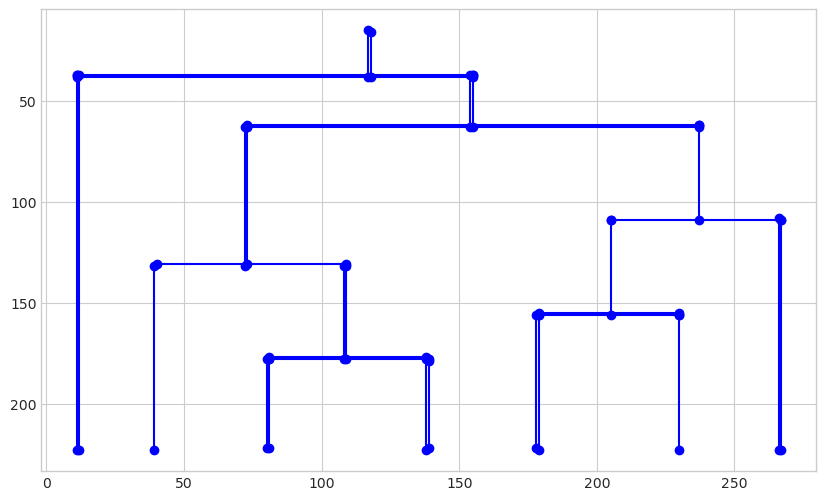

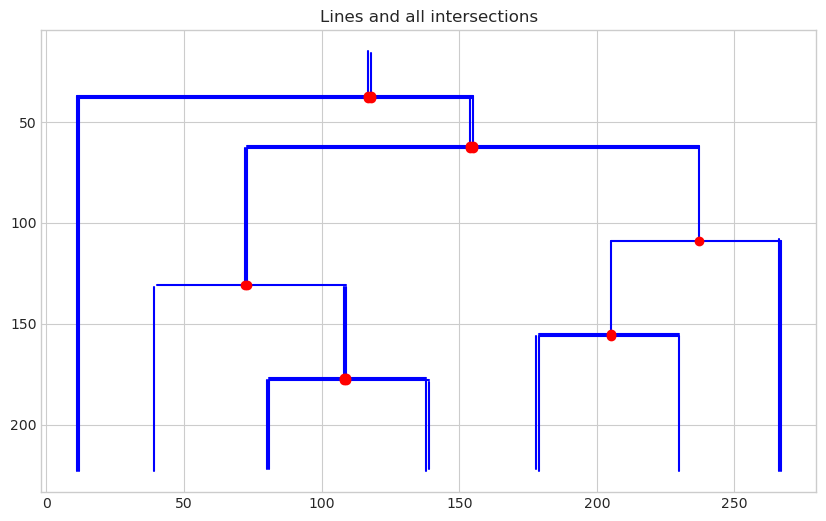

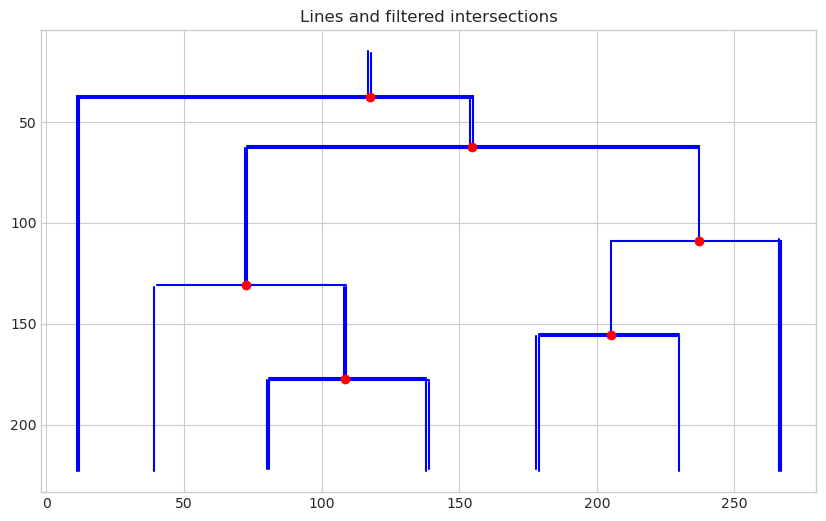

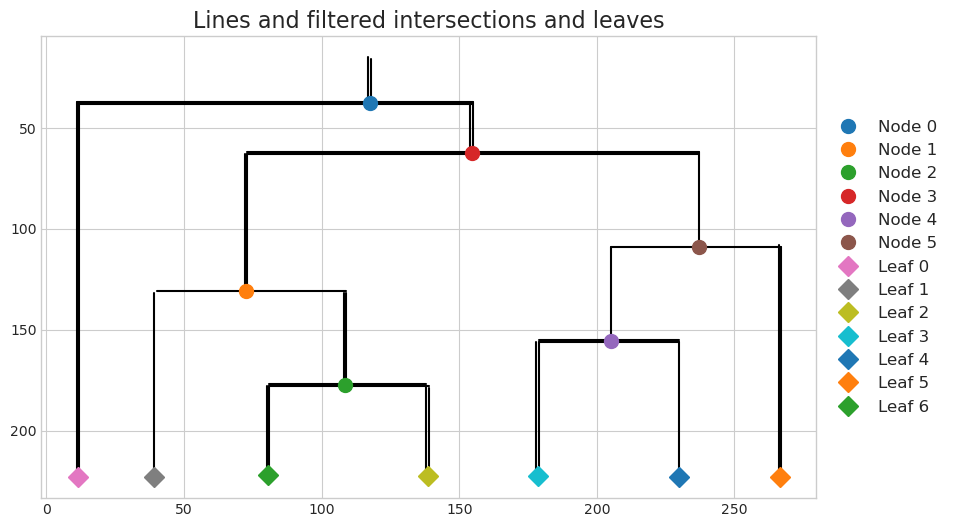

In [32]:
image = tc.TreeImage('../test_data/dendogram2.png')
_, _, internal_nodes, leaves, _ = image.find_lines_intersections_leaves(legend=True,
                                                                            orientation="vertical",
                                                                            intersection_threshold=5)

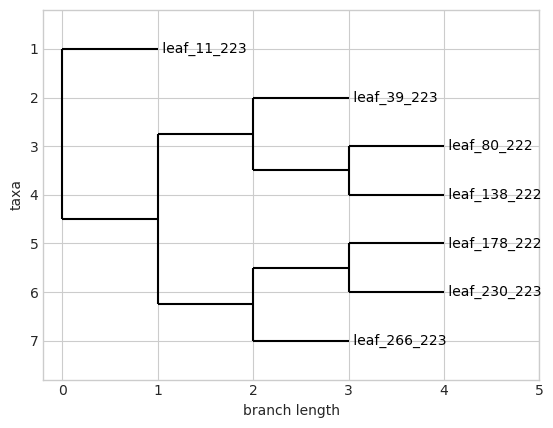

In [33]:
newick = generate_newick_str(leaves, internal_nodes, orientation='vertical')
save_to_newick(newick, '../newick_results/dendogram2.txt')
draw_newick(newick, '../newick_results/dendogram2.png')

Example 3

Tree image will be saved to ../test_data/tree6_tree.png.
Retrieved labels: Angus cattle White-tailed deer Blue whale Pygmy hippopotamus Wild boar Alpaca
Number of y points with frequency > 100: 16
Number of x points with frequency > 100: 7
[Step 1] finding and plotting all intersections
[Step 2] filtering internal nodes (line intersections)
Initial number of intersections = 13
After filtering number of intersections = 5
[Step 3] filtering leaves (line endings)
Initial number of intersections = 10
After filtering number of intersections = 6
[Summary] number of leaves = 6, number of nodes = 5


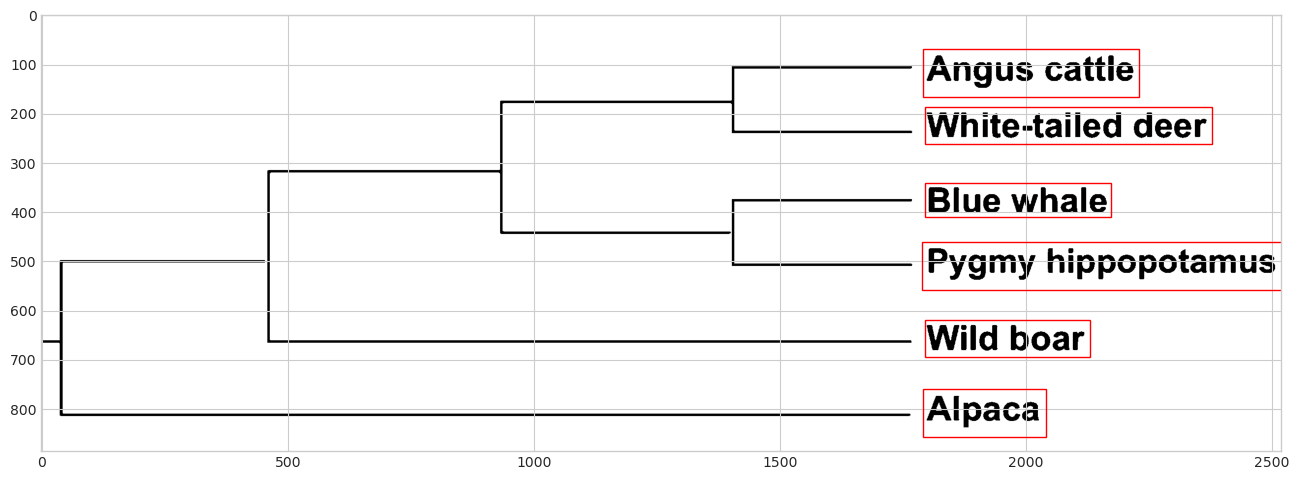

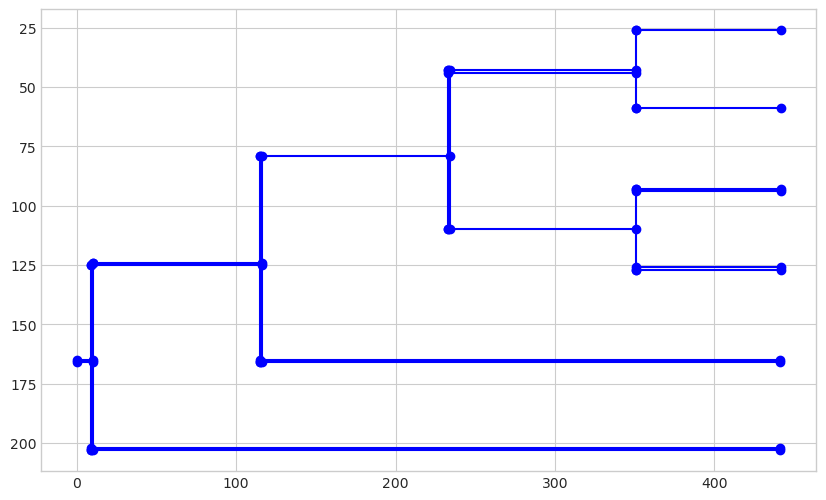

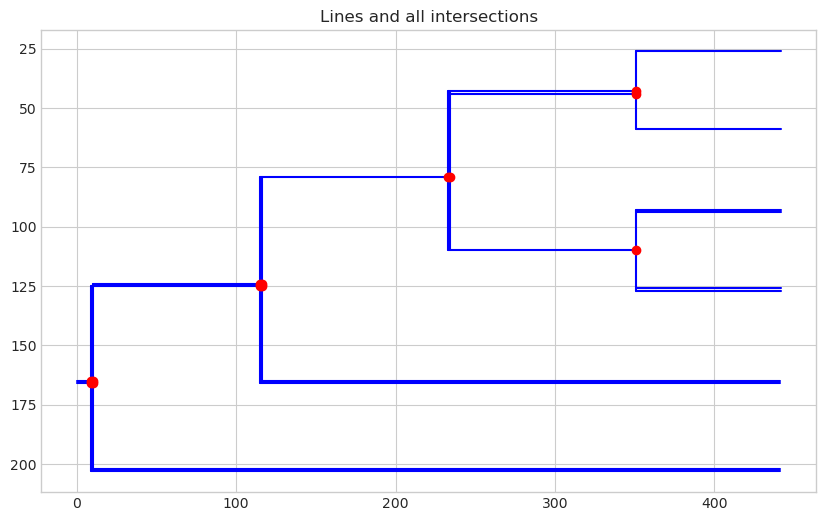

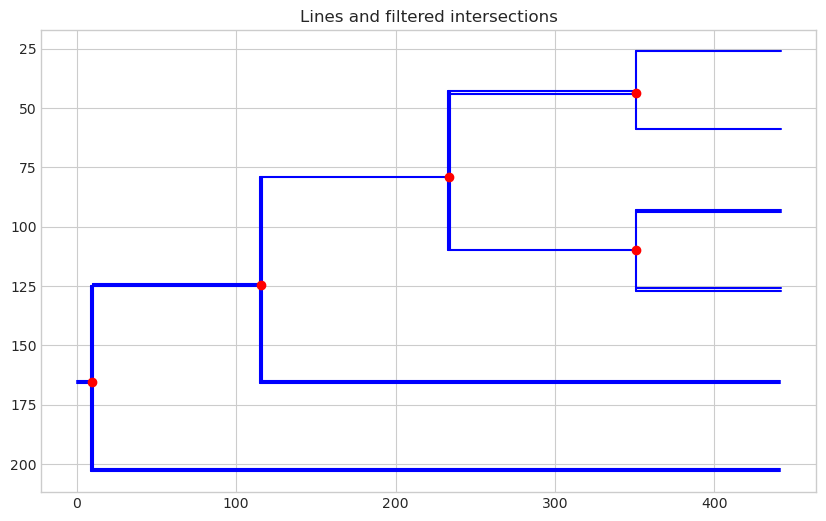

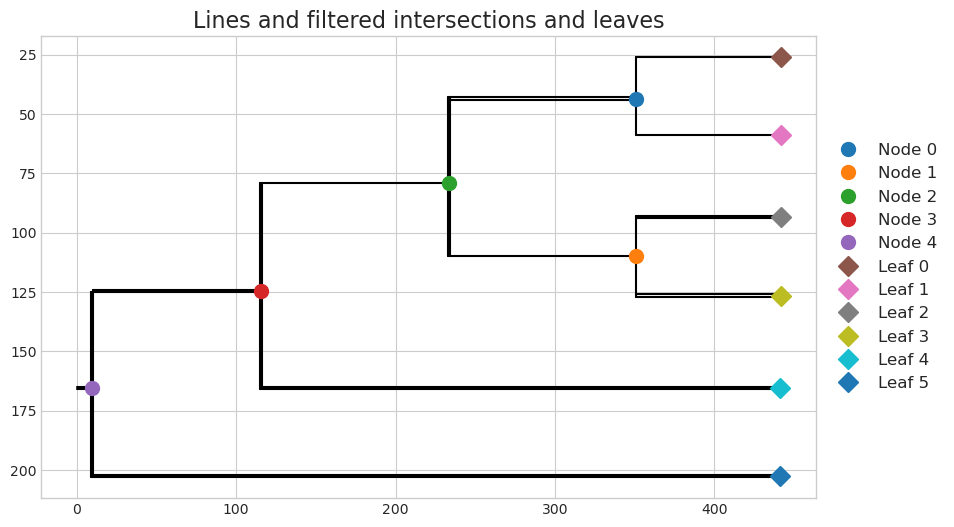

In [34]:
image = tc.Image('../test_data/tree6.png', resize_factor=0.25)
_, _, internal_nodes, leaves, _ = image.tree_image.find_lines_intersections_leaves(legend=True,orientation='horizontal',
                                                 intersection_threshold=5, min_freq=100)

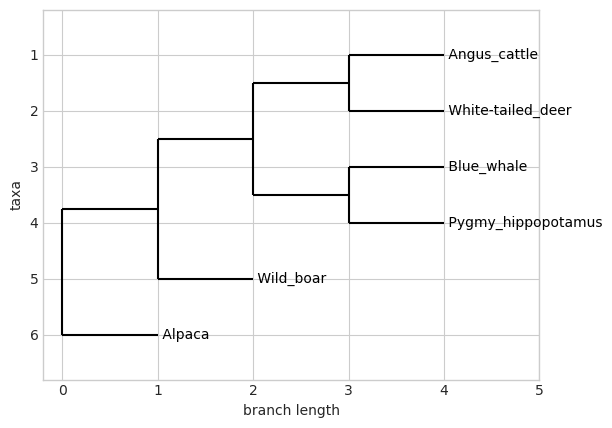

In [35]:
newick = generate_newick_str(leaves, internal_nodes, orientation='horizontal', labels=image.labels)
save_to_newick(newick, '../newick_results/tree6.txt')
draw_newick(newick, '../newick_results/tree6.png')

Example 4 - multifurcation - NOT WORKING WELL

Tree image will be saved to ../test_data/tree4_tree.png.
Retrieved labels: Porifera Cnidaria Echinodermata Hemichordata Chordata Bryozoa Annelida Mollusca Brachiopoda Arthropoda Onychophora Priapulida
Number of y points with frequency > 100: 80
Number of x points with frequency > 100: 333
[Step 1] finding and plotting all intersections
[Step 2] filtering internal nodes (line intersections)
Initial number of intersections = 176
After filtering number of intersections = 11
[Step 3] filtering leaves (line endings)
Initial number of intersections = 48
After filtering number of intersections = 12
[Summary] number of leaves = 12, number of nodes = 11


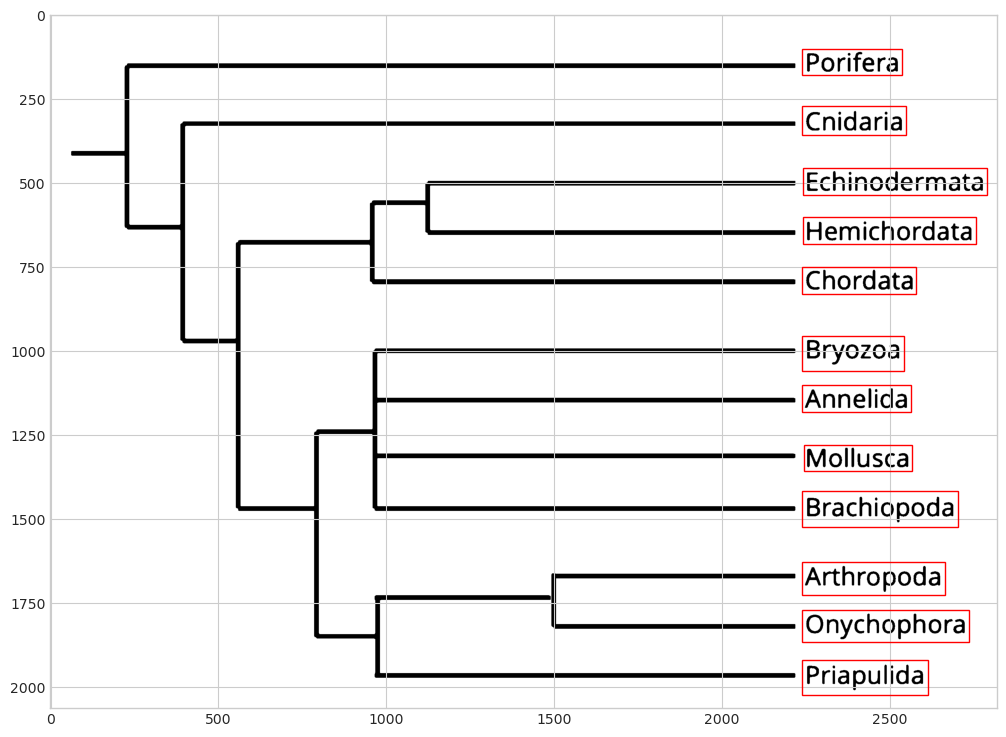

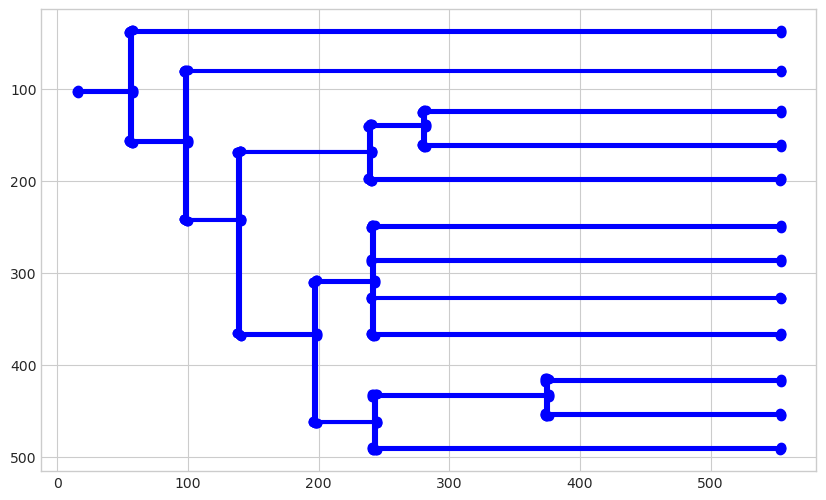

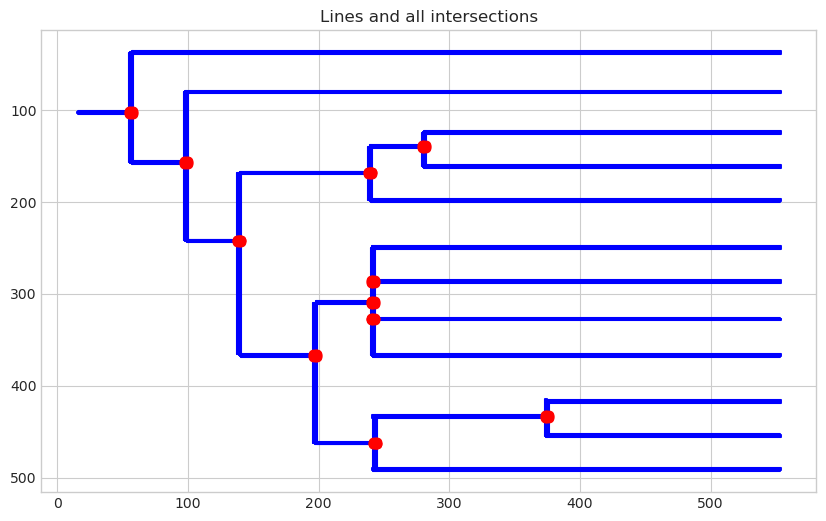

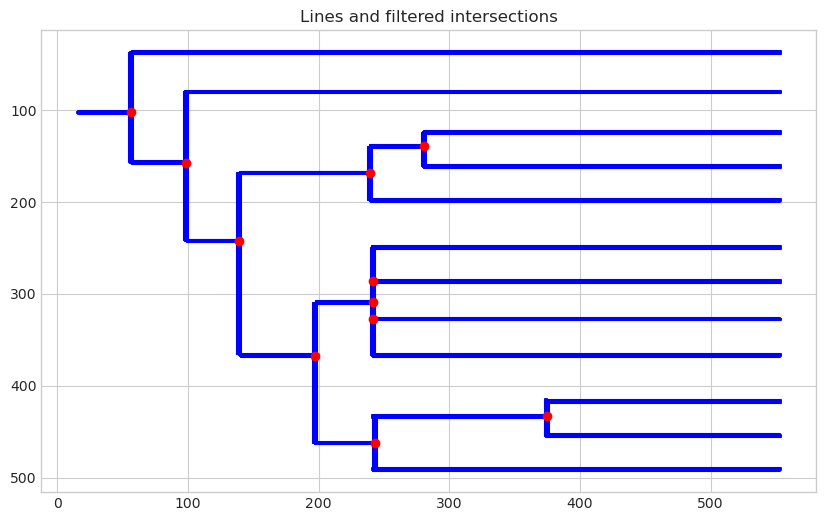

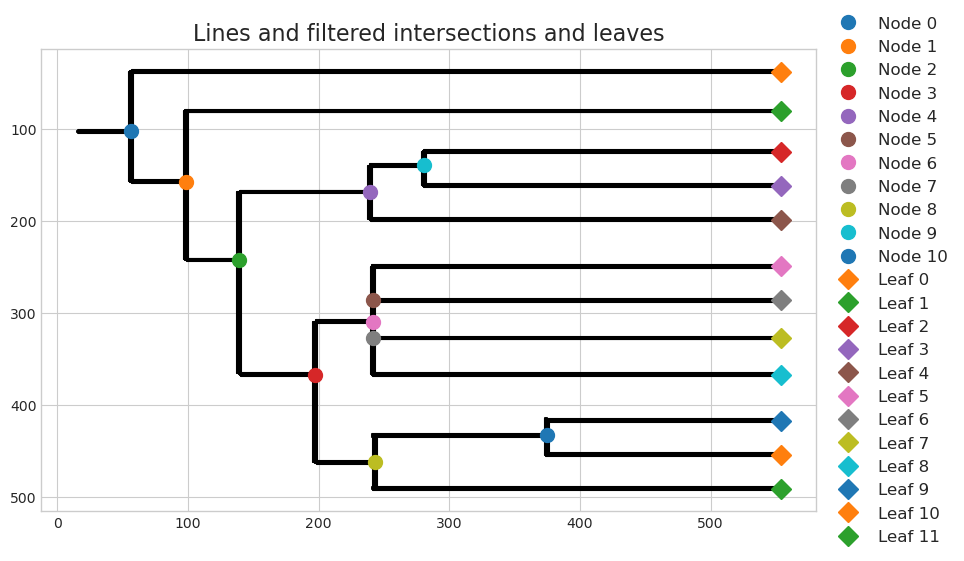

In [36]:
image = tc.Image('../test_data/tree4.png', resize_factor=0.25)
_, _, internal_nodes, leaves, _ = image.tree_image.find_lines_intersections_leaves(legend=True,orientation='horizontal',
                                                 intersection_threshold=7, min_freq=100)

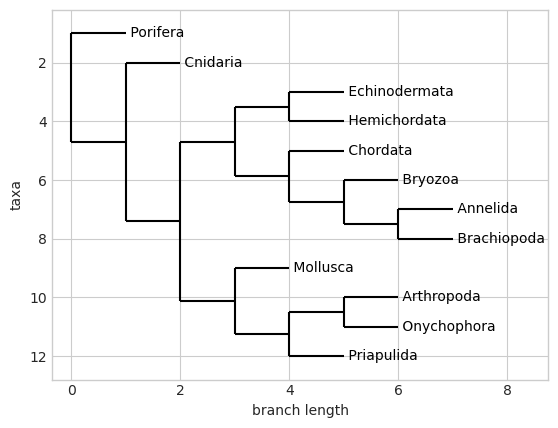

In [37]:
newick = generate_newick_str(leaves, internal_nodes, orientation='horizontal', labels=image.labels)
save_to_newick(newick, '../newick_results/tree4.txt')
draw_newick(newick, '../newick_results/tree4.png')